In [7]:
!pip install -q gymnasium[classic-control] torch matplotlib

import gymnasium as gym
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from collections import deque, defaultdict
import math, random, matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(0); np.random.seed(0); torch.manual_seed(0)

class DuelingQNet(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        hidden = 128
        self.feature = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
        )
        self.value_head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )
        self.adv_head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, act_dim),
        )

    def forward(self, x):
        h = self.feature(x)
        v = self.value_head(h)
        a = self.adv_head(h)
        return v + (a - a.mean(dim=1, keepdim=True))

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s,a,r,ns,d):
        self.buffer.append((s,a,r,ns,d))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s,a,r,ns,d = zip(*batch)
        def to_t(x, dt): return torch.tensor(x, dtype=dt, device=device)
        return to_t(s,torch.float32), to_t(a,torch.long), to_t(r,torch.float32), to_t(ns,torch.float32), to_t(d,torch.float32)
    def __len__(self): return len(self.buffer)

In [8]:
class DQNAgent:
    def __init__(self, obs_dim, act_dim, gamma=0.99, lr=1e-3, batch_size=64):
        self.q = DuelingQNet(obs_dim, act_dim).to(device)
        self.tgt = DuelingQNet(obs_dim, act_dim).to(device)
        self.tgt.load_state_dict(self.q.state_dict())
        self.buf = ReplayBuffer()
        self.opt = optim.Adam(self.q.parameters(), lr=lr)
        self.gamma = gamma
        self.batch_size = batch_size
        self.global_step = 0

    def _eps_value(self, step, start=1.0, end=0.05, decay=8000):
        return end + (start - end) * math.exp(-step/decay)

    def select_action(self, state, mode, strategy, softmax_temp=1.0):
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.q(s).cpu().numpy()[0]
        if mode == "eval":
            return int(np.argmax(q_vals)), None
        if strategy == "epsilon":
            eps = self._eps_value(self.global_step)
            if random.random() < eps:
                return random.randrange(len(q_vals)), eps
            return int(np.argmax(q_vals)), eps
        if strategy == "softmax":
            logits = q_vals / softmax_temp
            p = np.exp(logits - np.max(logits))
            p /= p.sum()
            return int(np.random.choice(len(q_vals), p=p)), None
        return int(np.argmax(q_vals)), None

    def train_step(self):
        if len(self.buf) < self.batch_size:
            return None
        s,a,r,ns,d = self.buf.sample(self.batch_size)
        with torch.no_grad():
            next_q_online = self.q(ns)
            next_actions = next_q_online.argmax(dim=1, keepdim=True)
            next_q_target = self.tgt(ns).gather(1, next_actions).squeeze(1)
            target = r + self.gamma * next_q_target * (1 - d)
        q_vals = self.q(s).gather(1, a.unsqueeze(1)).squeeze(1)
        loss = nn.MSELoss()(q_vals, target)
        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), 1.0)
        self.opt.step()
        return float(loss.item())

    def update_target(self):
        self.tgt.load_state_dict(self.q.state_dict())

    def run_episodes(self, env, episodes, mode, strategy):
        returns = []
        for _ in range(episodes):
            obs,_ = env.reset()
            done = False
            ep_ret = 0.0
            while not done:
                self.global_step += 1
                a,_ = self.select_action(obs, mode, strategy)
                nobs, r, term, trunc, _ = env.step(a)
                done = term or trunc
                if mode == "train":
                    self.buf.push(obs, a, r, nobs, float(done))
                    self.train_step()
                obs = nobs
                ep_ret += r
            returns.append(ep_ret)
        return float(np.mean(returns))

    def evaluate_across_levels(self, levels, episodes=5):
        scores = {}
        for name, max_steps in levels.items():
            env = gym.make("CartPole-v1", max_episode_steps=max_steps)
            avg = self.run_episodes(env, episodes, mode="eval", strategy="epsilon")
            env.close()
            scores[name] = avg
        return scores

In [9]:
class MetaAgent:
    def __init__(self, agent):
        self.agent = agent
        self.levels = {
            "EASY": 100,
            "MEDIUM": 300,
            "HARD": 500,
        }
        self.plans = []
        for diff in self.levels.keys():
            for mode in ["train", "eval"]:
                for expl in ["epsilon", "softmax"]:
                    self.plans.append((diff, mode, expl))
        self.counts = defaultdict(int)
        self.values = defaultdict(float)
        self.t = 0
        self.history = []

    def _ucb_score(self, plan, c=2.0):
        n = self.counts[plan]
        if n == 0:
            return float("inf")
        return self.values[plan] + c * math.sqrt(math.log(self.t+1) / n)

    def select_plan(self):
        self.t += 1
        scores = [self._ucb_score(p) for p in self.plans]
        return self.plans[int(np.argmax(scores))]

    def make_env(self, diff):
        max_steps = self.levels[diff]
        return gym.make("CartPole-v1", max_episode_steps=max_steps)

    def meta_reward_fn(self, diff, mode, avg_return):
        r = avg_return
        if diff == "MEDIUM": r += 20
        if diff == "HARD": r += 50
        if mode == "eval" and diff == "HARD": r += 50
        return r

    def update_plan_value(self, plan, meta_reward):
        self.counts[plan] += 1
        n = self.counts[plan]
        mu = self.values[plan]
        self.values[plan] = mu + (meta_reward - mu) / n

    def run(self, meta_rounds=30):
        eval_log = {"EASY":[], "MEDIUM":[], "HARD":[]}
        for k in range(1, meta_rounds+1):
            diff, mode, expl = self.select_plan()
            env = self.make_env(diff)
            avg_ret = self.agent.run_episodes(env, 5 if mode=="train" else 3, mode, expl if mode=="train" else "epsilon")
            env.close()
            if k % 3 == 0:
                self.agent.update_target()
            meta_r = self.meta_reward_fn(diff, mode, avg_ret)
            self.update_plan_value((diff,mode,expl), meta_r)
            self.history.append((k, diff, mode, expl, avg_ret, meta_r))
            if mode == "eval":
                eval_log[diff].append((k, avg_ret))
            print(f"{k} {diff} {mode} {expl} {avg_ret:.1f} {meta_r:.1f}")
        return eval_log

In [10]:
tmp_env = gym.make("CartPole-v1", max_episode_steps=100)
obs_dim, act_dim = tmp_env.observation_space.shape[0], tmp_env.action_space.n
tmp_env.close()

agent = DQNAgent(obs_dim, act_dim)
meta = MetaAgent(agent)

eval_log = meta.run(meta_rounds=36)

final_scores = agent.evaluate_across_levels(meta.levels, episodes=10)
print("Final Evaluation")
for k, v in final_scores.items():
    print(k, v)

1 EASY train epsilon 17.0 17.0
2 EASY train softmax 20.4 20.4
3 EASY eval epsilon 9.7 9.7
4 EASY eval softmax 10.0 10.0
5 MEDIUM train epsilon 22.6 42.6
6 MEDIUM train softmax 21.0 41.0
7 MEDIUM eval epsilon 14.3 34.3
8 MEDIUM eval softmax 16.0 36.0
9 HARD train epsilon 21.2 71.2
10 HARD train softmax 21.4 71.4
11 HARD eval epsilon 84.7 184.7
12 HARD eval softmax 113.0 213.0
13 HARD eval softmax 88.7 188.7
14 HARD eval softmax 98.0 198.0
15 HARD eval softmax 119.7 219.7
16 HARD eval softmax 86.3 186.3
17 HARD eval softmax 103.0 203.0
18 HARD eval softmax 131.0 231.0
19 HARD eval softmax 90.0 190.0
20 HARD eval softmax 104.0 204.0
21 HARD eval softmax 92.3 192.3
22 HARD eval softmax 90.0 190.0
23 HARD eval softmax 96.7 196.7
24 HARD eval softmax 97.3 197.3
25 HARD eval softmax 104.0 204.0
26 HARD eval softmax 105.0 205.0
27 HARD eval softmax 84.0 184.0
28 HARD eval softmax 133.3 233.3
29 HARD eval softmax 119.0 219.0
30 HARD eval softmax 108.7 208.7
31 HARD eval softmax 104.3 204.3
32 H

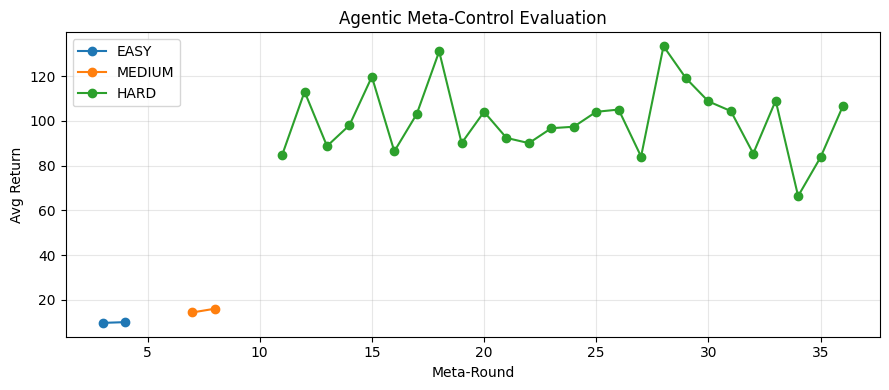

In [11]:
plt.figure(figsize=(9,4))
for diff, color in [("EASY","tab:blue"), ("MEDIUM","tab:orange"), ("HARD","tab:red")]:
    if eval_log[diff]:
        x, y = zip(*eval_log[diff])
        plt.plot(x, y, marker="o", label=f"{diff}")
plt.xlabel("Meta-Round")
plt.ylabel("Avg Return")
plt.title("Agentic Meta-Control Evaluation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()